# EEG to ECG Reconstruction


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import minmax_scale
from gpr_utils import train_pulse
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary

from lib.utils import seed_everything
from lib.plot_utils import visualize_ecg_and_peaks, plot_augmentation_example, plot_train_hystory, visualize_predictions
from lib.dataset_utils import create_segments_sliding, create_training_segments_with_augmentation, create_segments_nonoverlapping, augment_segment
from lib.train_utils import evaluate_loader, subject_mae
from scipy.signal import butter, sosfiltfilt

seed_everything(1234)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

pytorch version: 2.7.1+cu126
CUDA version: 12.6
Tesla T4
Using device: cuda


In [ ]:
# Configuration
A = 2              # Amplitude of the train pulses
width = 0.05       # Width of each pulse
tau = 5            # Lag (downsampling factor)
duration_sec = 10  # segment length

# Available subjects
subj_all = [29, 41, 30, 40, 23, 27, 28, 39]
test_subj = subj_all[0]
val_subj = subj_all[1]
train_subjects = [s for s in subj_all if s not in (test_subj, val_subj)]

# Pulse type for ECG transformation Gaussian or Rectangular
impulse = "Gaussian"

# Augmentation settings
use_augmentation = True
warp_factor_range = (0.85, 1.15)
aug_segment_duration = round(warp_factor_range[1] * duration_sec)       # seconds (larger than target to allow warping)
n_augmented_per_segment = 5

# Training settings
train_overlap = 0.9
batch_size = 16
learning_rate = 1e-3
epochs = 100
patience = 40

# Paths
cache_dir = "cache"
os.makedirs(cache_dir, exist_ok=True)
parsed_path = os.path.join(cache_dir, "data_parsed.pkl")
preproc_path = os.path.join(cache_dir, "data_preprocessed.pkl")

# Heart-rate band filtering (~1 Hz)
use_hr_band_filter = True
lowcut=0.1
highcut=16

# Use only the first N seconds of each subject (after downsampling)
dataset_max_seconds = 120

# Classification settings (R-peak detection as per-timestep classification)
peak_window_s = 0.06          # label +1 for samples within ±peak_window_s around each R-peak
min_peak_distance_s = 0.4     # auxiliary constraint when detecting peaks in pulse targets
cls_threshold = 0.5            # threshold on peak probability for visualization

# Regularization and optimization
weight_decay = 1e-4
label_smoothing = 0.05
use_focal = False             # set True to try focal loss
focal_gamma = 2.0
focal_alpha = 0.75
max_grad_norm = 2.0
lr_plateau_factor = 0.5
lr_plateau_patience = 8

# Online augmentation (applied each batch during training)
aug_noise_std = 0.02          # Gaussian noise std (0 disables)
aug_channel_dropout_p = 0.10  # per-channel dropout prob (0 disables)
aug_time_mask_ratio = 0.05    # fraction of time to mask per sample (0 disables)
use_mixup = True
mixup_alpha = 0.2

# Metrics threshold for per-timestep classification
metrics_threshold = 0.5

## Load, Parse and Preprocess

Loaded parsed and preprocess data from cache


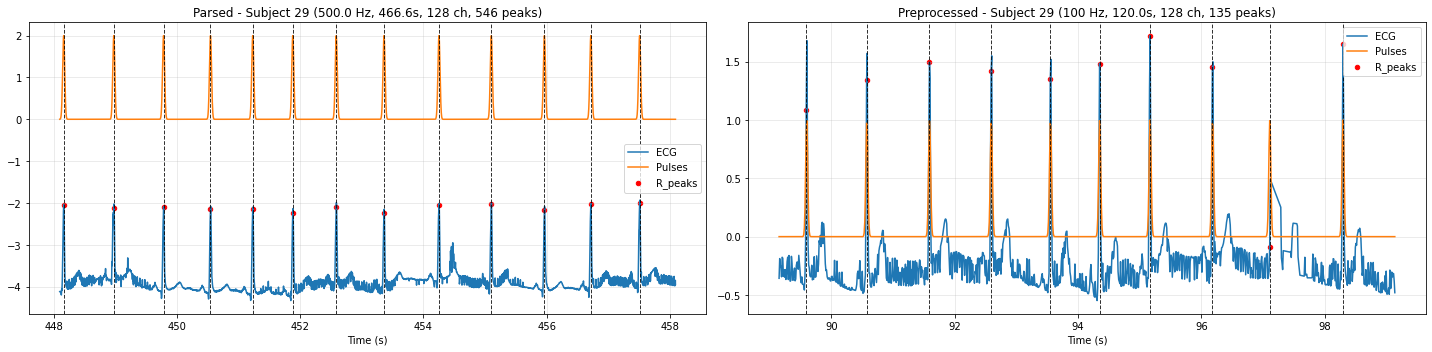

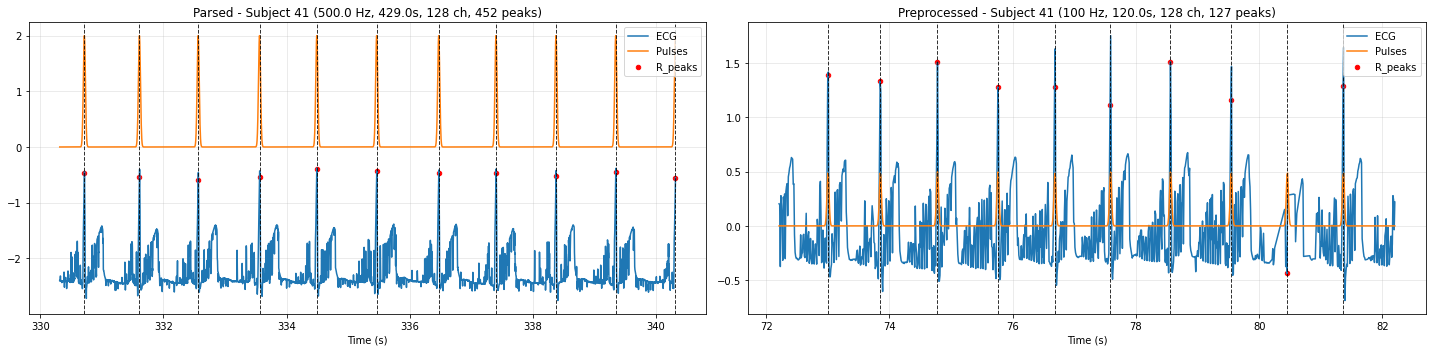

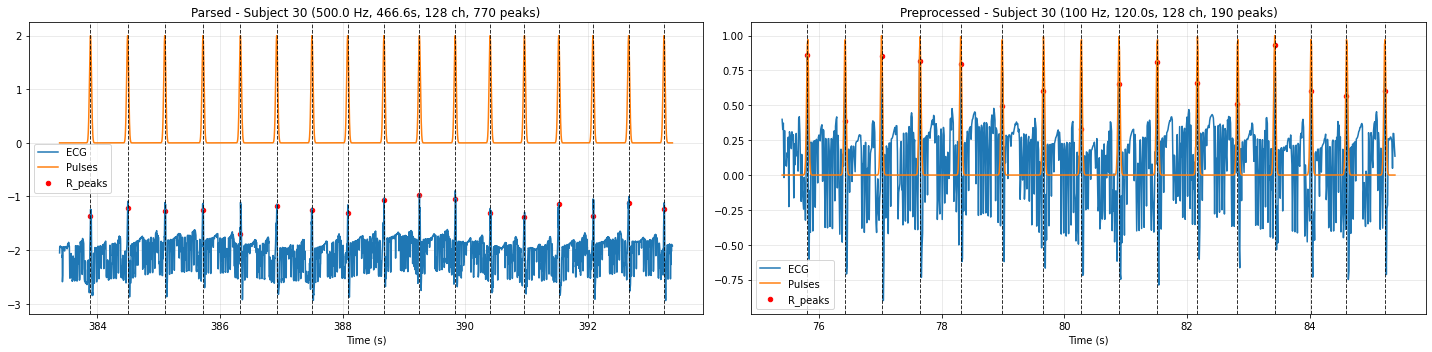

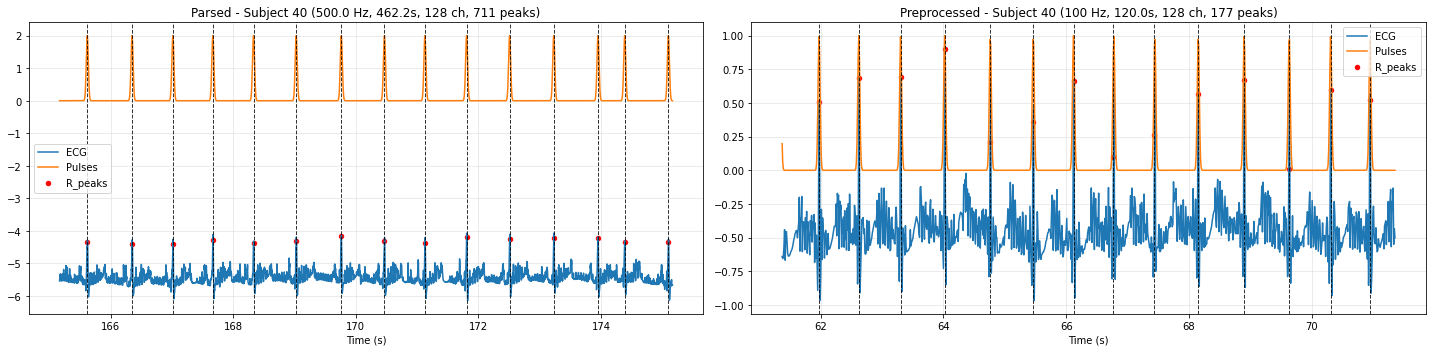

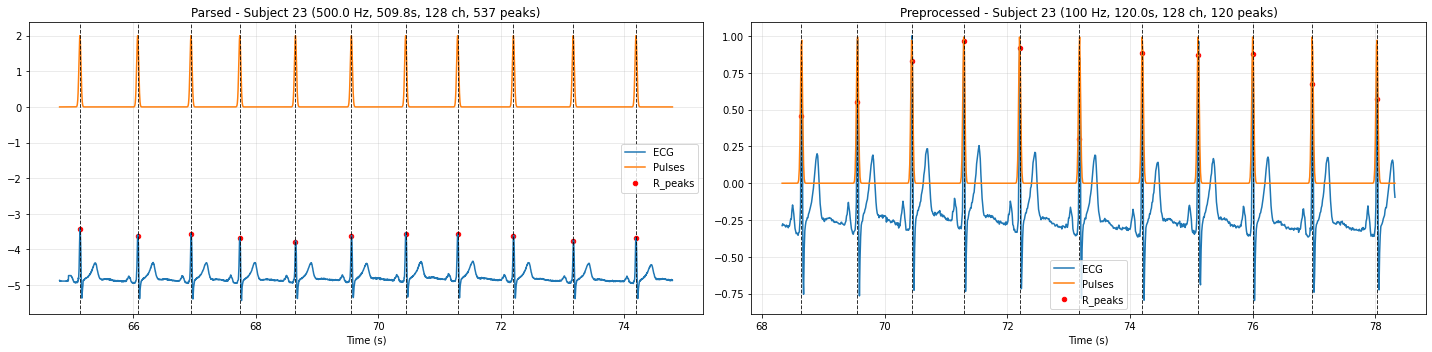

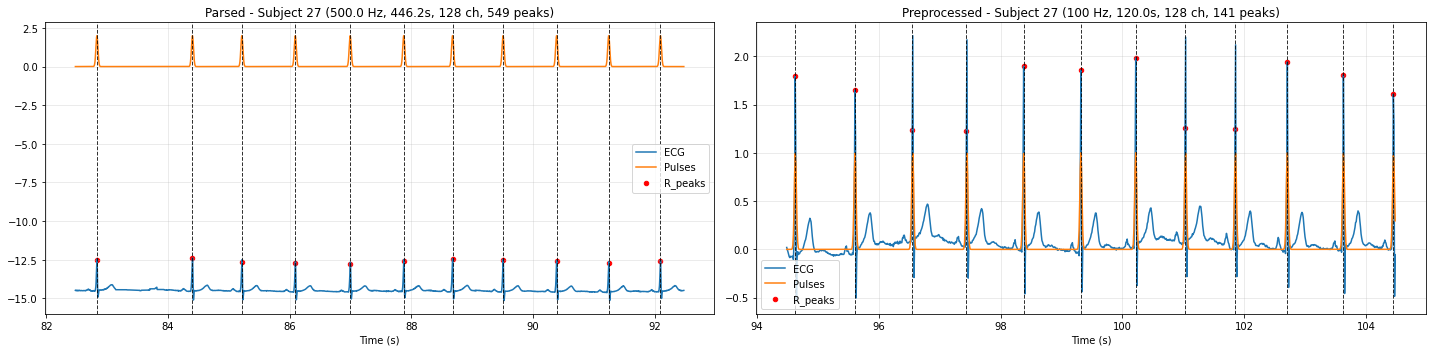

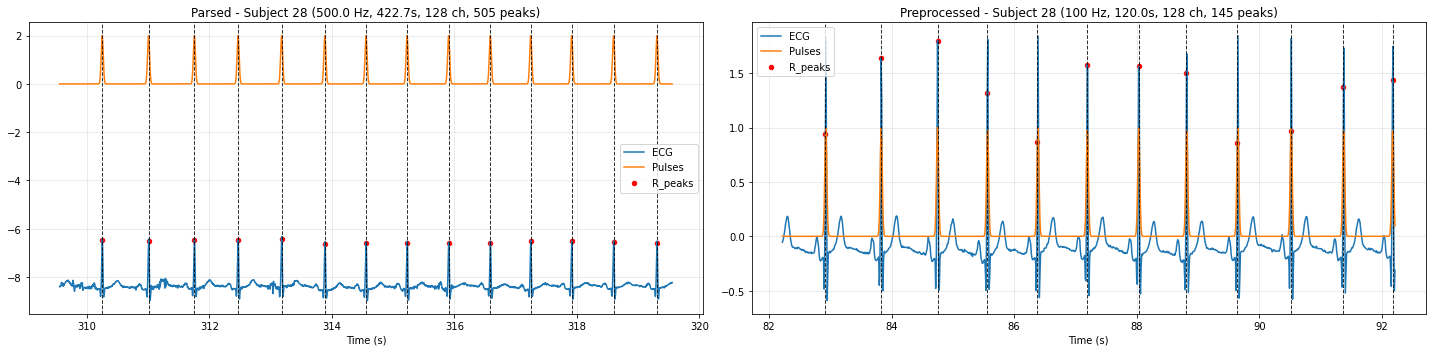

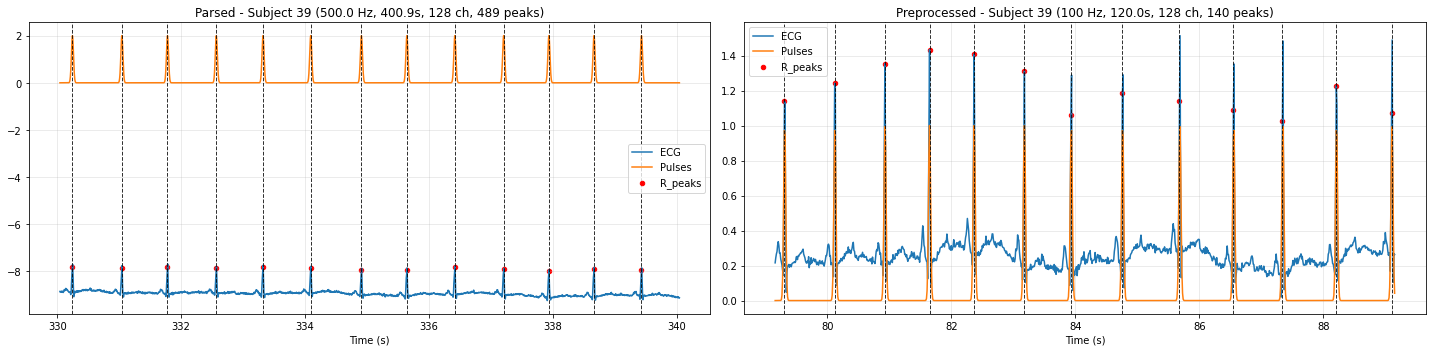

In [16]:
def load_subject_data(subj_id, A, width, impulse):
    """Load and parse data for a single subject."""
    # Load preprocessed EEG
    data = loadmat(f'Signals/P0{subj_id:02d}_prepro.mat')
    EEG_prepro = data['EEG_prepro']
    Y_prepro = EEG_prepro['data'][0, 0].astype(float)
    freq_prepro = float(EEG_prepro['srate'][0, 0])

    # Load ECG
    ecg_data = loadmat(f'Signals/P0{subj_id:02d}.mat')
    t_prepro = ecg_data["t_int"].flatten()
    t_prepro = np.insert(t_prepro, 0, 0.0)

    R_peak = ecg_data['R_peak'].flatten() - 1
    ECG = ecg_data['ECG_i'].flatten()
    ECG = np.insert(ECG, len(ECG), ECG[-1])

    # Generate pulse train
    ECG_pulse = train_pulse(Y_prepro, R_peak, A, width, freq_prepro, impulse)

    return { 'ECG': ECG, 'ECG_pulse': ECG_pulse, 'R_peaks': R_peak, 'EEG': Y_prepro, 'time': t_prepro, 'freq': freq_prepro }


def bandpass_eeg(x, fs, lowcut=0.1, highcut=22.5, order=4):
    nyq = fs / 2.0
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sosfiltfilt(sos, x, axis=-1)


def preprocess_subject_data(subject_data, tau):
    """Normalize and downsample subject data."""
    ECG = subject_data['ECG'].copy() - np.mean(subject_data['ECG'])
    ECG = ECG[::tau]  # downsample

    ECG_pulse = minmax_scale(subject_data['ECG_pulse'].copy().reshape(1, -1), feature_range=(0, 1), axis=1).flatten()
    ECG_pulse = ECG_pulse[::tau]

    EEG = minmax_scale(subject_data['EEG'].copy(), feature_range=(0, 1), axis=1)
    EEG = EEG - np.mean(EEG, axis=1, keepdims=True)  # Subtract per channel mean

    # Compute downsampled frequency
    freq = int(subject_data['freq'] / tau)

    # Downsample EEG
    EEG = EEG[:, ::tau]

    R_peaks = subject_data['R_peaks'].copy() // tau
    time = subject_data['time'].copy()[::tau]

    return {
        'ECG': ECG,
        'ECG_pulse': ECG_pulse,
        'R_peaks': R_peaks,
        'EEG': EEG,
        'time': time,
        'freq': freq
    }

# Load parsed data
if os.path.exists(parsed_path) and os.path.exists(preproc_path):
    with open(parsed_path, "rb") as f:
        data_parsed = pickle.load(f)
    with open(preproc_path, "rb") as f:
        data_preprocessed = pickle.load(f)
    print(f"Loaded parsed and preprocess data from cache")
else:
    print("Loading and parsing raw data...")
    data_parsed = {}
    data_preprocessed = {}
    for ss in subj_all:
        print(f"  Loading subject {ss}...")
        data_parsed[ss] = load_subject_data(ss, A, width, impulse)
        data_preprocessed[ss] = preprocess_subject_data(data_parsed[ss], tau)
    with open(parsed_path, "wb") as f:
        pickle.dump(data_parsed, f)
    print(f"Saved to {parsed_path}")
    with open(preproc_path, "wb") as f:
        pickle.dump(data_preprocessed, f)
    print(f"Saved to {preproc_path}")

# Apply HR band-pass AFTER loading (works with PKL cache)
if use_hr_band_filter:
    for ss in subj_all:
        fs_ds = int(data_preprocessed[ss]['freq'])
        eeg_unfilt = np.asarray(data_preprocessed[ss]['EEG'], dtype=float)
        data_preprocessed[ss]['EEG_unfilt'] = eeg_unfilt
        data_preprocessed[ss]['EEG'] = bandpass_eeg(eeg_unfilt, fs_ds, lowcut=lowcut, highcut=highcut)

# Trim all signals to the first dataset_max_seconds seconds
if dataset_max_seconds is not None:
    for ss in subj_all:
        fs_ds = int(data_preprocessed[ss]['freq'])
        max_samples = int(dataset_max_seconds * fs_ds)
        # Bound against available length
        T = data_preprocessed[ss]['EEG'].shape[1]
        max_samples = min(max_samples, T)

        # Slice time-series
        data_preprocessed[ss]['EEG'] = data_preprocessed[ss]['EEG'][:, :max_samples]
        if 'EEG_unfilt' in data_preprocessed[ss]:
            data_preprocessed[ss]['EEG_unfilt'] = data_preprocessed[ss]['EEG_unfilt'][:, :max_samples]
        data_preprocessed[ss]['ECG'] = data_preprocessed[ss]['ECG'][:max_samples]
        data_preprocessed[ss]['ECG_pulse'] = data_preprocessed[ss]['ECG_pulse'][:max_samples]
        data_preprocessed[ss]['time'] = data_preprocessed[ss]['time'][:max_samples]

        # Keep R-peaks within the window
        rps = np.asarray(data_preprocessed[ss]['R_peaks'])
        data_preprocessed[ss]['R_peaks'] = rps[rps < max_samples]

# Visualize parsed data
for ss in subj_all:
    visualize_ecg_and_peaks(ss, data_parsed[ss], data_preprocessed[ss], duration_sec)

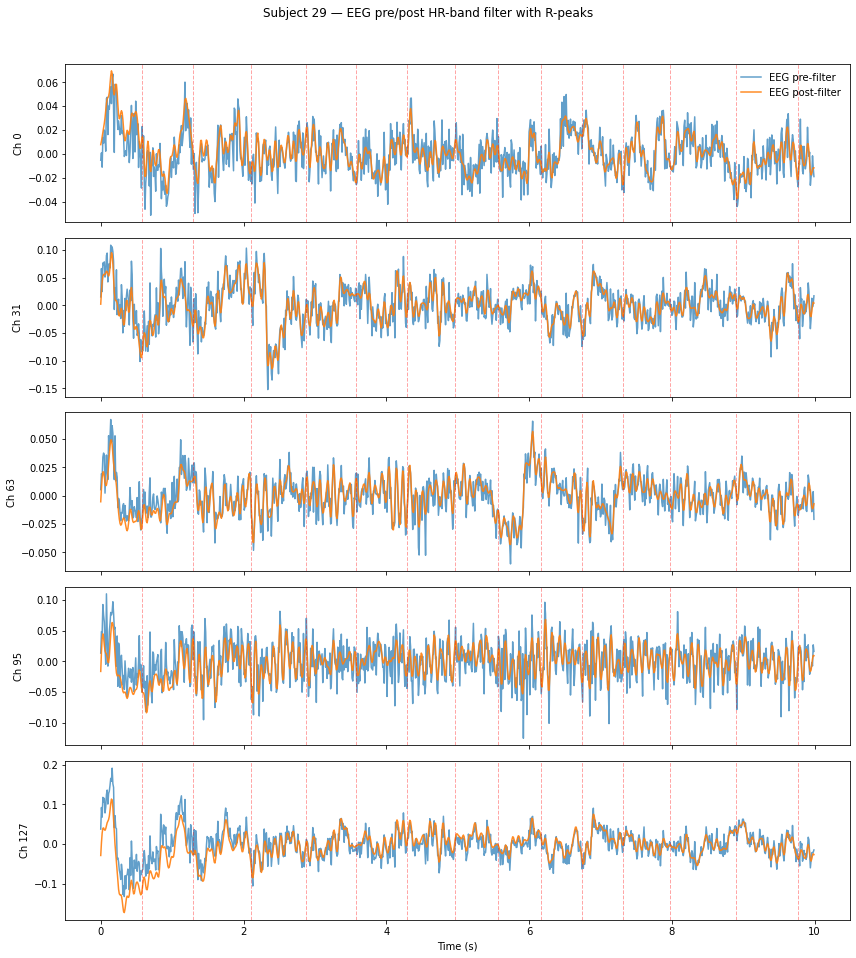

In [17]:
# EEG pre/post-filter visualization with R-peaks (5 channels) + residual and metrics
plot_subj = test_subj  # subject to visualize

pre_ds = data_preprocessed[plot_subj].get('EEG_unfilt', None)
post_ds = data_preprocessed[plot_subj]['EEG']
fs_ds = data_preprocessed[plot_subj]['freq']
rpeaks_ds = data_preprocessed[plot_subj]['R_peaks']

# Reconstruct pre-filter downsampled EEG if not present in cache
if pre_ds is None:
    raw = data_parsed[plot_subj]['EEG'].copy()  # (C, T_full)
    raw = minmax_scale(raw, feature_range=(0, 1), axis=1)
    raw = raw - np.mean(raw, axis=1, keepdims=True)
    pre_ds = raw[:, ::tau]

n_channels = pre_ds.shape[0]
n_samp = min(int(duration_sec * fs_ds), pre_ds.shape[1])  # plot up to duration_sec
t = np.arange(pre_ds.shape[1]) / fs_ds

# Select 5 channels evenly across the montage
n_plot = 5
chan_idx = np.linspace(0, n_channels - 1, n_plot, dtype=int)
fig, axes = plt.subplots(n_plot, 1, figsize=(12, 2.6 * n_plot), sharex=True)

for i, ch in enumerate(chan_idx):
    ax = axes[i]
    y0 = pre_ds[ch, :n_samp]
    y1 = post_ds[ch, :n_samp]

    ax.plot(t[:n_samp], y0, label='EEG pre-filter', color='C0', alpha=0.7)
    ax.plot(t[:n_samp], y1, label='EEG post-filter', color='C1', alpha=0.9)

    # R-peak vertical lines (downsampled indices)
    for rp in rpeaks_ds:
        if 0 <= rp < n_samp:
            ax.axvline(t[rp], color='r', linestyle='--', alpha=0.35, linewidth=1)
    ax.set_ylabel(f"Ch {ch}")
    if i == 0:
        ax.legend(loc='upper right', frameon=False)

axes[-1].set_xlabel('Time (s)')
fig.suptitle(f'Subject {plot_subj} — EEG pre/post HR-band filter with R-peaks', y=1.02)
plt.tight_layout()
plt.show()

## Segmentation and Train/Val/Test Split

In [18]:
downsampled_frequency = data_preprocessed[subj_all[0]]['freq']
seg_len = int(duration_sec * downsampled_frequency)
aug_seg_len = int(aug_segment_duration * downsampled_frequency) if use_augmentation else seg_len
train_stride = max(1, int(seg_len * (1.0 - train_overlap)))
n_channels = data_preprocessed[subj_all[0]]['EEG'].shape[0]

print(f"Test subject: {test_subj} | Val subject: {val_subj} | Train subject: {train_subjects}")
print(f"Frequency: {downsampled_frequency} Hz | Segment length: {seg_len} samples ({duration_sec}s)")
print(f"Train overlap: {train_overlap:.2f}")

if use_augmentation:
    print(f"Augmentation: {n_augmented_per_segment}x per segment")
    print(f"Warp range: {warp_factor_range}")

print(f"Classification: window=±{peak_window_s:.3f}s, min_peak_distance={min_peak_distance_s:.2f}s")

Test subject: 29 | Val subject: 41 | Train subject: [30, 40, 23, 27, 28, 39]
Frequency: 100 Hz | Segment length: 1000 samples (10s)
Train overlap: 0.90
Augmentation: 5x per segment
Warp range: (0.85, 1.15)
Classification: window=±0.060s, min_peak_distance=0.40s


In [19]:
X_train_list, y_train_list, ecg_train_list, train_ids_list = [], [], [], []

for s in train_subjects:
    print(f"Processing training subject {s}...", end="")
    
    if use_augmentation:
        X_s, y_s, ecg_s = create_training_segments_with_augmentation(
            data_preprocessed[s], aug_seg_len, seg_len, train_stride,
            warp_factor_range, n_augmented_per_segment
        )
        print(f"  Created {X_s.shape[0]} segments (with augmentation)")
    else:
        X_s, y_s, ecg_s = create_segments_sliding(
            data_preprocessed[s]['EEG'],
            data_preprocessed[s]['ECG_pulse'],
            data_preprocessed[s]['ECG'],
            seg_len, train_stride
        )
        print(f"  Created {X_s.shape[0]} segments")
    
    X_train_list.append(X_s)
    y_train_list.append(y_s)
    ecg_train_list.append(ecg_s)
    train_ids_list.append(np.full((X_s.shape[0],), s, dtype=np.int32))

# Build validation set (non-overlapping)
print(f"\nProcessing validation subject {val_subj}...", end="")
X_val, y_val, ECG_val = create_segments_nonoverlapping(
    data_preprocessed[val_subj]['EEG'],
    data_preprocessed[val_subj]['ECG_pulse'],
    data_preprocessed[val_subj]['ECG'],
    seg_len
)
print(f"  Created {X_val.shape[0]} segments")

# Build test set (non-overlapping)
print(f"Processing test subject {test_subj}...", end="")
X_test, y_test, ECG_test = create_segments_nonoverlapping(
    data_preprocessed[test_subj]['EEG'],
    data_preprocessed[test_subj]['ECG_pulse'],
    data_preprocessed[test_subj]['ECG'],
    seg_len
)
print(f"  Created {X_test.shape[0]} segments")

# Concatenate training data
X_train = np.concatenate(X_train_list, axis=0) if X_train_list else np.empty((0, seg_len, n_channels))
y_train = np.concatenate(y_train_list, axis=0) if y_train_list else np.empty((0, seg_len))
ECG_train = np.concatenate(ecg_train_list, axis=0) if ecg_train_list else np.empty((0, seg_len))
train_seg_subjects = np.concatenate(train_ids_list, axis=0) if train_ids_list else np.empty((0,), dtype=np.int32)

print(f"\nFinal dataset:")
print(f"  Train: {X_train.shape}")
print(f"  Val: {X_val.shape}")
print(f"  Test: {X_test.shape}")

# Build per-timestep binary labels (0=non-peak, 1=peak) using intervals around pulse peaks
from scipy.signal import find_peaks

def build_binary_labels_from_peaks(peaks_idx, T, half_w):
    y = np.zeros((T,), dtype=np.int64)
    for p in peaks_idx:
        a = max(0, int(p - half_w))
        b = min(T, int(p + half_w) + 1)
        y[a:b] = 1
    return y

fs_ds = int(downsampled_frequency)
half_w = max(1, int(round(peak_window_s * fs_ds)))
min_dist = max(1, int(round(min_peak_distance_s * fs_ds)))

def labels_from_pulse_segments(Y_pulse):
    N, T = Y_pulse.shape
    Ycls = np.zeros((N, T), dtype=np.int64)
    for i in range(N):
        # detect pulse peaks and label ±window
        pks, _ = find_peaks(Y_pulse[i], distance=min_dist, height=0.15, prominence=0.05)
        Ycls[i] = build_binary_labels_from_peaks(pks, T, half_w)
    return Ycls

y_train_cls = labels_from_pulse_segments(y_train) if X_train.shape[0] else np.empty((0, seg_len), dtype=np.int64)
y_val_cls = labels_from_pulse_segments(y_val) if X_val.shape[0] else np.empty((0, seg_len), dtype=np.int64)
y_test_cls = labels_from_pulse_segments(y_test) if X_test.shape[0] else np.empty((0, seg_len), dtype=np.int64)

pos_count = int(y_train_cls.sum()) if y_train_cls.size else 1
neg_count = int(y_train_cls.size - pos_count) if y_train_cls.size else 1
print(f"Class balance (train): pos={pos_count}, neg={neg_count}, pos_ratio={pos_count/(pos_count+neg_count):.4f}")

Processing training subject 30...  Created 660 segments (with augmentation)
Processing training subject 40...  Created 660 segments (with augmentation)
Processing training subject 40...  Created 660 segments (with augmentation)
Processing training subject 23...  Created 660 segments (with augmentation)
Processing training subject 23...  Created 660 segments (with augmentation)
Processing training subject 27...  Created 660 segments (with augmentation)
Processing training subject 27...  Created 660 segments (with augmentation)
Processing training subject 28...  Created 660 segments (with augmentation)
Processing training subject 28...  Created 660 segments (with augmentation)
Processing training subject 39...  Created 660 segments (with augmentation)
Processing training subject 39...  Created 660 segments (with augmentation)

Processing validation subject 41...  Created 12 segments
Processing test subject 29...  Created 12 segments
  Created 660 segments (with augmentation)

Processing 

In [20]:
# Create PyTorch datasets and loaders (classification targets)
X_train_t = torch.from_numpy(X_train.astype(np.float32))
y_train_t = torch.from_numpy(y_train_cls.astype(np.int64))
X_val_t = torch.from_numpy(X_val.astype(np.float32))
y_val_t = torch.from_numpy(y_val_cls.astype(np.int64))
X_test_t = torch.from_numpy(X_test.astype(np.float32))
y_test_t = torch.from_numpy(y_test_cls.astype(np.int64))

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print(f"Created data loaders with training batch_size={batch_size}")

Created data loaders with training batch_size=16


## Model Definition

In [21]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.dropout = nn.Dropout(dropout) if dropout > 0.0 else nn.Identity()

    def forward(self, x):
        return self.dropout(self.net(x))


class UNet1D(nn.Module):
    def __init__(self, in_ch, base_ch=32, out_ch=2, dropout=0.2):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(in_ch, base_ch, dropout)
        self.pool1 = nn.MaxPool1d(2)
        self.enc2 = ConvBlock(base_ch, base_ch * 2, dropout)
        self.pool2 = nn.MaxPool1d(2)
        self.enc3 = ConvBlock(base_ch * 2, base_ch * 4, dropout)
        self.pool3 = nn.MaxPool1d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(base_ch * 4, base_ch * 8, dropout)

        # Decoder
        self.up3 = nn.ConvTranspose1d(base_ch * 8, base_ch * 4, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(base_ch * 8, base_ch * 4, dropout)
        self.up2 = nn.ConvTranspose1d(base_ch * 4, base_ch * 2, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(base_ch * 4, base_ch * 2, dropout)
        self.up1 = nn.ConvTranspose1d(base_ch * 2, base_ch, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(base_ch * 2, base_ch, dropout)

        self.out_conv = nn.Conv1d(base_ch, out_ch, kernel_size=1)  # logits for 2 classes (non-peak, peak)

    def forward(self, x):
        x = x.transpose(1, 2)  # (B, T, C) -> (B, C, T)
        
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        
        b = self.bottleneck(self.pool3(e3))
        
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        
        out = self.out_conv(d1)  # (B, 2, T)
        return out  # logits


model = UNet1D(in_ch=n_channels, base_ch=8, out_ch=2, dropout=0.5).to(device)

summary(model, input_size=(1, seg_len, n_channels), col_names=["input_size", "output_size", "num_params"], depth=4)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
UNet1D                                   [1, 1000, 128]            [1, 2, 1000]              --
├─ConvBlock: 1-1                         [1, 128, 1000]            [1, 8, 1000]              --
│    └─Sequential: 2-1                   [1, 128, 1000]            [1, 8, 1000]              --
│    │    └─Conv1d: 3-1                  [1, 128, 1000]            [1, 8, 1000]              3,080
│    │    └─BatchNorm1d: 3-2             [1, 8, 1000]              [1, 8, 1000]              16
│    │    └─ReLU: 3-3                    [1, 8, 1000]              [1, 8, 1000]              --
│    │    └─Conv1d: 3-4                  [1, 8, 1000]              [1, 8, 1000]              200
│    │    └─BatchNorm1d: 3-5             [1, 8, 1000]              [1, 8, 1000]              16
│    │    └─ReLU: 3-6                    [1, 8, 1000]              [1, 8, 1000]              --
│    └─Dropout: 2-2            

In [ ]:
# Online augmentation helpers and optional FocalLoss
def apply_online_augmentations(xb):
    # xb: (B, T, C)
    if aug_noise_std > 0:
        noise = torch.randn_like(xb) * aug_noise_std
        xb = xb + noise
    if aug_channel_dropout_p > 0:
        B, T, C = xb.shape
        mask = (torch.rand(B, C, device=xb.device) > aug_channel_dropout_p).float()
        # ensure at least one channel kept per sample
        for b in range(B):
            if mask[b].sum() == 0:
                mask[b, torch.randint(0, C, (1,))] = 1.0
        mask = mask.unsqueeze(1)  # (B,1,C) broadcast over time
        xb = xb * mask
    if aug_time_mask_ratio > 0:
        B, T, C = xb.shape
        L = max(1, int(T * aug_time_mask_ratio))
        starts = torch.randint(0, max(1, T - L + 1), (B,), device=xb.device)
        for b in range(B):
            s = int(starts[b].item())
            xb[b, s:s+L, :] = 0.0
    return xb

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.75, weight=None):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.weight = weight
    def forward(self, logits, targets):
        # logits: (B, 2, T), targets: (B, T)
        B, C, T = logits.shape
        logits_flat = logits.permute(0,2,1).reshape(-1, C)
        targets_flat = targets.reshape(-1)
        ce = nn.functional.cross_entropy(logits_flat, targets_flat, weight=self.weight, reduction='none')
        pt = torch.exp(-ce)
        alpha_t = torch.full_like(targets_flat, fill_value=1.0 - self.alpha, dtype=torch.float32)
        alpha_t = alpha_t.to(logits.device)
        alpha_t = torch.where(targets_flat == 1, torch.full_like(alpha_t, self.alpha), alpha_t)
        loss = alpha_t * (1 - pt) ** self.gamma * ce
        return loss.mean()

## Training

Starting training (classification, ES on val F1)...
Epoch 01 - loss: 0.60980 | val loss: 0.81405 | val F1=0.1952 | test F1=0.3971
Epoch 01 - loss: 0.60980 | val loss: 0.81405 | val F1=0.1952 | test F1=0.3971
Epoch 02 - loss: 0.39801 | val loss: 0.80171 | val F1=0.2478 | test F1=0.4212
Epoch 02 - loss: 0.39801 | val loss: 0.80171 | val F1=0.2478 | test F1=0.4212
Epoch 03 - loss: 0.32029 | val loss: 0.90721 | val F1=0.2470 | test F1=0.3599
Epoch 03 - loss: 0.32029 | val loss: 0.90721 | val F1=0.2470 | test F1=0.3599
Epoch 04 - loss: 0.29293 | val loss: 1.07844 | val F1=0.2144 | test F1=0.3661
Epoch 04 - loss: 0.29293 | val loss: 1.07844 | val F1=0.2144 | test F1=0.3661
Epoch 05 - loss: 0.27236 | val loss: 1.16651 | val F1=0.2098 | test F1=0.4056
Epoch 05 - loss: 0.27236 | val loss: 1.16651 | val F1=0.2098 | test F1=0.4056
Epoch 06 - loss: 0.25639 | val loss: 1.34758 | val F1=0.2085 | test F1=0.4088
Epoch 06 - loss: 0.25639 | val loss: 1.34758 | val F1=0.2085 | test F1=0.4088
Epoch 07 - l

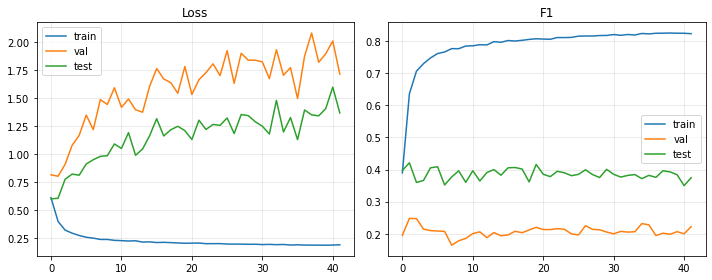

In [ ]:
from lib.train_utils import check_early_stopping  # no longer used for ES criteria
torch.use_deterministic_algorithms(True, warn_only=True)

def compute_batch_metrics(logits, y_true, threshold=None):
    # logits: (B, 2, T), y_true: (B, T)
    with torch.no_grad():
        if threshold is None:
            preds = logits.argmax(dim=1)  # (B, T)
        else:
            probs = torch.softmax(logits, dim=1)[:, 1, :]  # (B, T)
            preds = (probs >= threshold).long()
        y = y_true
        tp = ((preds == 1) & (y == 1)).sum().item()
        tn = ((preds == 0) & (y == 0)).sum().item()
        fp = ((preds == 1) & (y == 0)).sum().item()
        fn = ((preds == 0) & (y == 1)).sum().item()
        total = tp + tn + fp + fn + 1e-12
        acc = (tp + tn) / total
        prec = tp / (tp + fp + 1e-12)
        rec = tp / (tp + fn + 1e-12)
        f1 = 2 * prec * rec / (prec + rec + 1e-12)
    return acc, f1

def evaluate_loader_cls(model, loader, device, criterion, threshold=None):
    model.eval()
    total_loss, total_acc, total_f1, batches = 0.0, 0.0, 0.0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)  # (B, 2, T)
            loss = criterion(logits, yb)
            acc, f1 = compute_batch_metrics(logits, yb, threshold=threshold)
            total_loss += loss.item()
            total_acc += acc
            total_f1 += f1
            batches += 1
    return total_loss / max(1, batches), total_acc / max(1, batches), total_f1 / max(1, batches)

# Class weights for imbalance
pos = float(y_train_cls.sum()) if y_train_cls.size else 1.0
neg = float(y_train_cls.size - pos) if y_train_cls.size else 1.0
w_neg = (pos + neg) / (2.0 * max(neg, 1.0))
w_pos = (pos + neg) / (2.0 * max(pos, 1.0))
class_weights = torch.tensor([w_neg, w_pos], dtype=torch.float32, device=device)

# Loss, optimizer, scheduler
criterion = FocalLoss(gamma=focal_gamma, alpha=focal_alpha, weight=class_weights) if use_focal else nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_plateau_factor, patience=lr_plateau_patience, verbose=True)

train_loss_hist, val_loss_hist, test_loss_hist = [], [], []
train_f1_hist, val_f1_hist, test_f1_hist = [], [], []
best_state = None
wait = 0
best_epoch = 0
best_f1 = -1.0

print("Starting training (classification, ES on val F1) with regularization and online augmentation...")
for epoch in range(1, epochs + 1):
    model.train()
    running_loss, running_acc, running_f1, n_batches = 0.0, 0.0, 0.0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        # online augmentations
        xb_aug = apply_online_augmentations(xb) if (aug_noise_std>0 or aug_channel_dropout_p>0 or aug_time_mask_ratio>0) else xb
        optimizer.zero_grad()
        if use_mixup and mixup_alpha > 0:
            lam = np.random.beta(mixup_alpha, mixup_alpha)
            idx = torch.randperm(xb_aug.size(0), device=xb_aug.device)
            mixed = lam * xb_aug + (1 - lam) * xb_aug[idx]
            logits = model(mixed)
            loss = lam * criterion(logits, yb) + (1 - lam) * criterion(logits, yb[idx])
        else:
            logits = model(xb_aug)
            loss = criterion(logits, yb)
        loss.backward()
        if max_grad_norm is not None and max_grad_norm > 0:
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        acc, f1 = compute_batch_metrics(logits.detach(), yb, threshold=metrics_threshold)
        running_loss += loss.item()
        running_acc += acc
        running_f1 += f1
        n_batches += 1
    train_loss = running_loss / max(1, n_batches)
    train_acc = running_acc / max(1, n_batches)
    train_f1 = running_f1 / max(1, n_batches)

    val_loss, val_acc, val_f1 = evaluate_loader_cls(model, val_loader, device, criterion, threshold=metrics_threshold)
    test_loss, test_acc, test_f1 = evaluate_loader_cls(model, test_loader, device, criterion, threshold=metrics_threshold)
    scheduler.step(val_loss)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    test_loss_hist.append(test_loss)
    train_f1_hist.append(train_f1)
    val_f1_hist.append(val_f1)
    test_f1_hist.append(test_f1)
    print(f"Epoch {epoch:02d} - loss: {train_loss:.5f} | val loss: {val_loss:.5f} | val F1={val_f1:.4f} | test F1={test_f1:.4f}")

    if val_f1 > best_f1 + 1e-8:
        best_f1 = val_f1
        best_state = model.state_dict()
        best_epoch = epoch
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping triggered (no val F1 improvement for {patience} epochs).")
            break

if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)
    print(f"Restored best model from epoch {best_epoch} with val F1={best_f1:.4f}")

# Plot training curves (loss and F1)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(train_loss_hist, label='train'); plt.plot(val_loss_hist, label='val'); plt.plot(test_loss_hist, label='test'); plt.title('Loss'); plt.legend(); plt.grid(True, alpha=0.3)
plt.subplot(1,2,2); plt.plot(train_f1_hist, label='train'); plt.plot(val_f1_hist, label='val'); plt.plot(test_f1_hist, label='test'); plt.title('F1'); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

### Threshold tuning on validation

In [ ]:
# Sweep probability threshold on validation to maximize F1, then reuse for metrics
def sweep_threshold(model, loader, device, criterion, thr_list):
    best_thr, best_f1 = None, -1.0
    for thr in thr_list:
        _, _, val_f1 = evaluate_loader_cls(model, loader, device, criterion, threshold=thr)
        if val_f1 > best_f1:
            best_f1, best_thr = val_f1, thr
    return best_thr, best_f1

thr_grid = np.linspace(0.2, 0.8, 13)
best_thr, best_thr_f1 = sweep_threshold(model, val_loader, device, criterion, thr_grid)
if best_thr is not None:
    metrics_threshold = float(best_thr)
    print(f"Selected metrics_threshold={metrics_threshold:.2f} (val F1={best_thr_f1:.4f})")
else:
    print("Threshold sweep failed; keeping default metrics_threshold.")

## Evaluation and Visualization

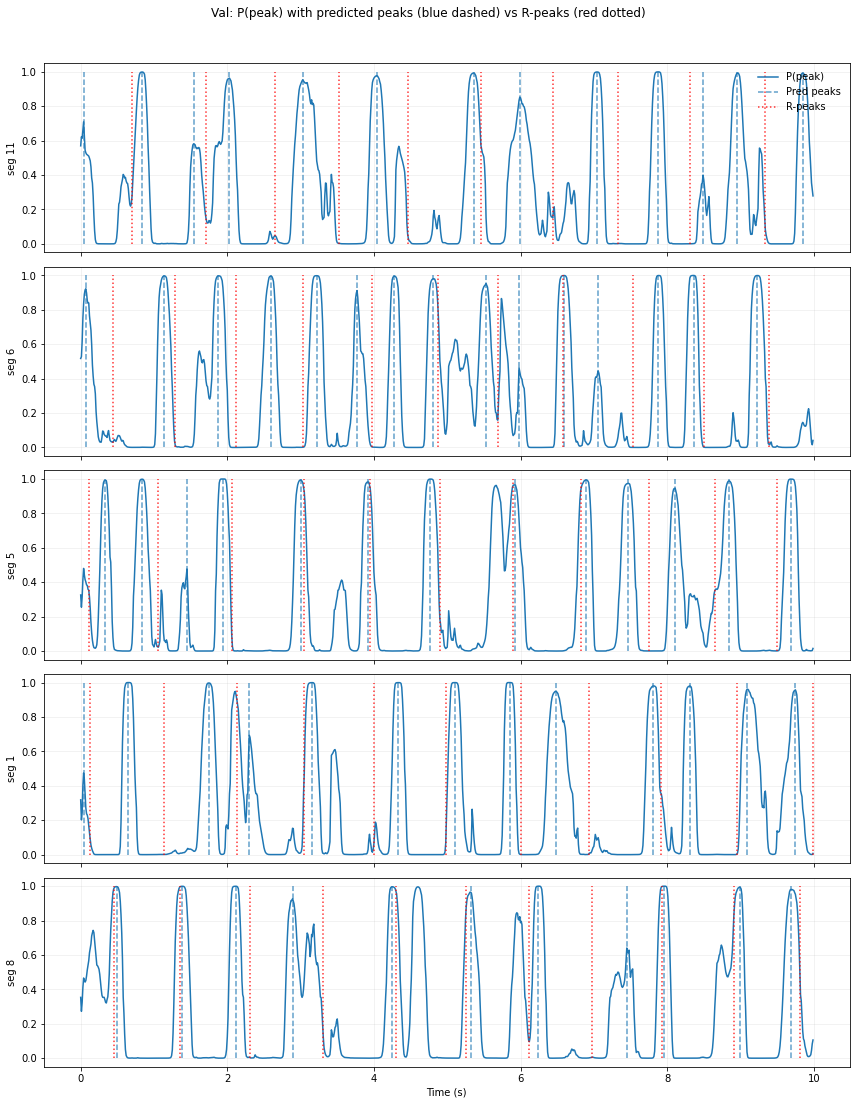

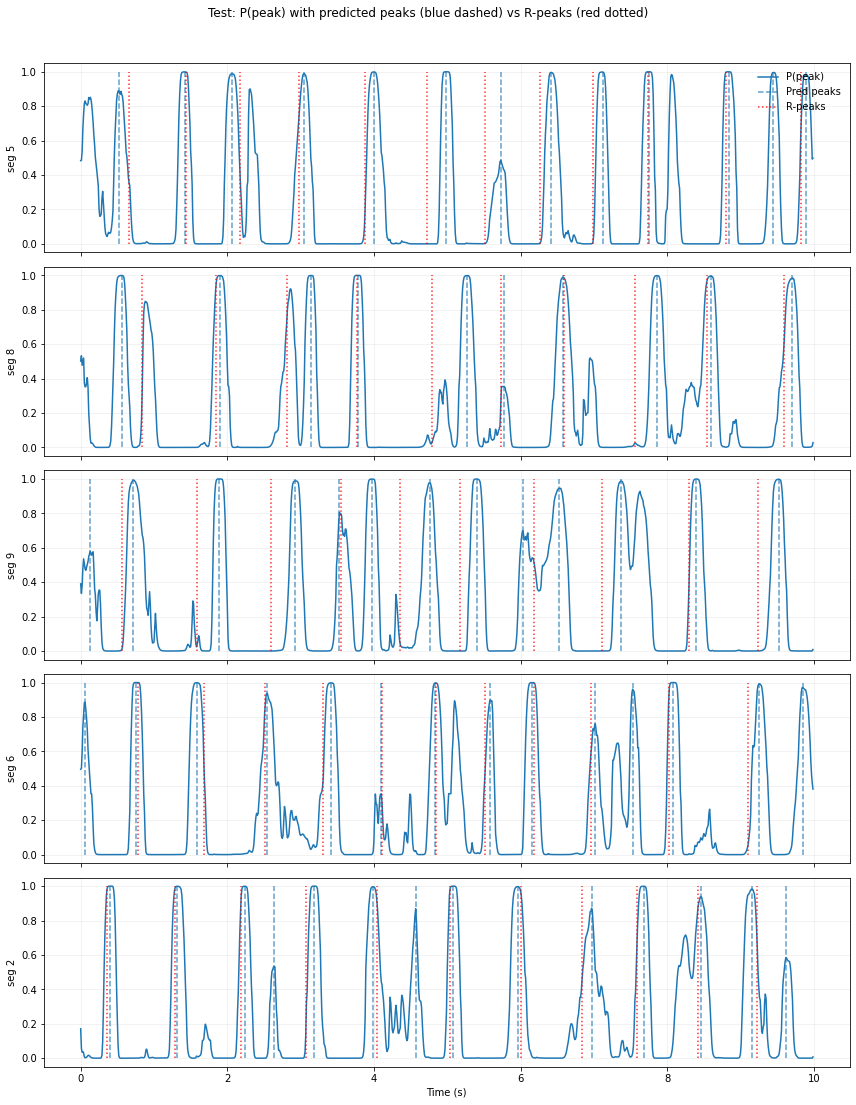

In [ ]:
# Visualization (classification): show predicted peak probability vs R-peaks
from scipy.signal import find_peaks

def visualize_peak_predictions(split_name, X_set, rpeaks_abs, fs, model, seg_len, device, K=5, height=0.30, prominence=0.10, min_distance_s=0.4):
    if X_set.shape[0] == 0:
        print(f"[{split_name}] empty set")
        return
    min_distance_samples = max(1, int(min_distance_s * fs))
    Kp = min(K, X_set.shape[0])
    rng = np.random.default_rng()
    seg_indices = rng.choice(X_set.shape[0], size=Kp, replace=False)
    t_seg = np.arange(seg_len) / fs
    fig, axes = plt.subplots(Kp, 1, figsize=(12, 3.0 * Kp), sharex=True)
    if Kp == 1: axes = [axes]
    model.eval()
    with torch.no_grad():
        for ax, i in zip(axes, seg_indices):
            xb = torch.from_numpy(X_set[i:i+1].astype(np.float32)).to(device)  # (1, T, C)
            logits = model(xb)  # (1, 2, T)
            probs = torch.softmax(logits, dim=1)[0, 1].cpu().numpy()  # (T,) prob of peak
            peaks_pred, _ = find_peaks(probs, distance=min_distance_samples, height=height, prominence=0.1)
            seg_start = i * seg_len
            seg_end = seg_start + probs.shape[0]
            in_seg = (rpeaks_abs >= seg_start) & (rpeaks_abs < seg_end)
            rpeaks_rel = (rpeaks_abs[in_seg] - seg_start).astype(int)
            ax.plot(t_seg, probs, label='P(peak)', color='C0')
            if peaks_pred.size:
                ax.vlines(t_seg[peaks_pred], ymin=0.0, ymax=1.0, colors='C0', linestyles='dashed', alpha=0.7, label='Pred peaks')
            if rpeaks_rel.size:
                ax.vlines(t_seg[rpeaks_rel], ymin=0.0, ymax=1.0, colors='r', linestyles='dotted', alpha=0.8, label='R-peaks')
            ax.set_ylabel(f"seg {i}")
            ax.grid(True, alpha=0.2)
        axes[0].legend(loc='upper right', frameon=False)
    axes[-1].set_xlabel('Time (s)')
    plt.suptitle(f"{split_name}: P(peak) with predicted peaks (blue dashed) vs R-peaks (red dotted)", y=1.02)
    plt.tight_layout()
    plt.show()

# Prepare absolute R-peaks for val/test
fs_val = int(data_preprocessed[val_subj]['freq'])
rpeaks_val_abs = np.asarray(data_preprocessed[val_subj]['R_peaks'], dtype=int)
fs_test = int(data_preprocessed[test_subj]['freq'])
rpeaks_test_abs = np.asarray(data_preprocessed[test_subj]['R_peaks'], dtype=int)

visualize_peak_predictions('Val', X_val, rpeaks_val_abs, fs_val, model, seg_len, device, K=5)
visualize_peak_predictions('Test', X_test, rpeaks_test_abs, fs_test, model, seg_len, device, K=5)

In [ ]:
# Final evaluation (classification) using tuned metrics_threshold
val_loss, val_acc, val_f1 = evaluate_loader_cls(model, val_loader, device, criterion, threshold=metrics_threshold)
test_loss, test_acc, test_f1 = evaluate_loader_cls(model, test_loader, device, criterion, threshold=metrics_threshold)

print(f"\nFinal Results (thr={metrics_threshold:.2f}):")
print(f"  Val:  loss={val_loss:.5f}, acc={val_acc:.4f}, F1={val_f1:.4f}")
print(f"  Test: loss={test_loss:.5f}, acc={test_acc:.4f}, F1={test_f1:.4f}")


Final Results:
  Val:  loss=1.71307, acc=0.6823, F1=0.2220
  Test: loss=1.36666, acc=0.7524, F1=0.3747


[Val] Peak timing MAE: 0.2169s | median: 0.1900s | p90: 0.4130s | Npeaks=168 | dist=40 smp
[Test] Peak timing MAE: 0.1715s | median: 0.1200s | p90: 0.4140s | Npeaks=159 | dist=40 smp


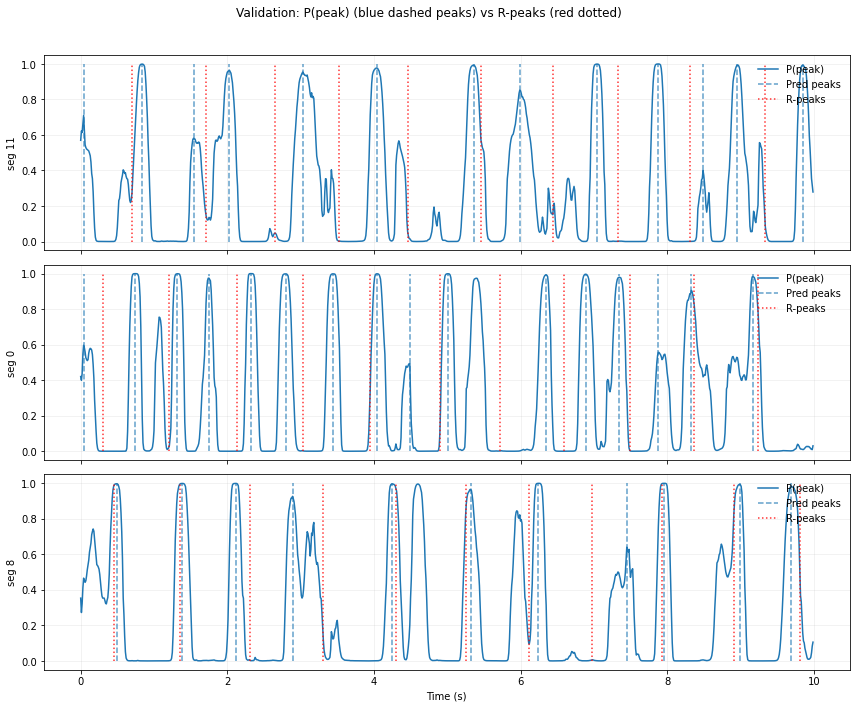

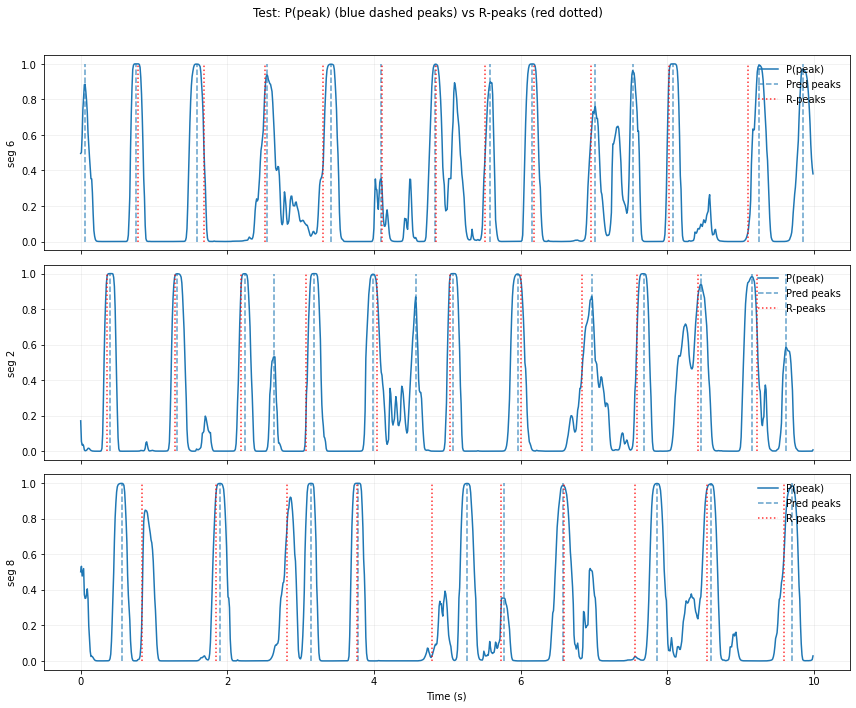

In [28]:
# Plot predicted peaks vs actual R-peaks on random val/test segments, and compute timing stats (classification version)
from scipy.signal import find_peaks

model.eval()

def nearest_diffs_samples(peaks_abs, r_abs):
    if peaks_abs.size == 0 or r_abs.size == 0:
        return np.empty((0,), dtype=float)
    diffs = []
    for p in peaks_abs:
        j = np.searchsorted(r_abs, p)
        cand = []
        if j < r_abs.size:
            cand.append(abs(r_abs[j] - p))
        if j > 0:
            cand.append(abs(r_abs[j - 1] - p))
        if cand:
            diffs.append(min(cand))
    return np.asarray(diffs, dtype=float)

def compute_peak_mae_for_set_cls(X_set, rpeaks_abs, fs, seg_len, height=0.30, prominence=0.10, min_distance_s=0.4):
    min_distance_samples = max(1, int(min_distance_s * fs))
    all_diffs = []
    total_pred_peaks = 0
    with torch.no_grad():
        for i in range(X_set.shape[0]):
            xb = torch.from_numpy(X_set[i:i+1].astype(np.float32)).to(device)  # (1, T, C)
            logits = model(xb)  # (1, 2, T)
            probs = torch.softmax(logits, dim=1)[0, 1].cpu().numpy()  # (T,)
            peaks_pred, _ = find_peaks(probs, distance=min_distance_samples, height=height, prominence=prominence)
            total_pred_peaks += int(peaks_pred.size)
            seg_start = i * seg_len
            peaks_abs = peaks_pred + seg_start
            diffs = nearest_diffs_samples(peaks_abs, rpeaks_abs)
            if diffs.size:
                all_diffs.append(diffs)
    if len(all_diffs) == 0:
        return None, total_pred_peaks, min_distance_samples
    diffs_cat = np.concatenate(all_diffs)
    stats = {
        'mae_sec': float(diffs_cat.mean() / fs),
        'median_sec': float(np.median(diffs_cat) / fs),
        'p90_sec': float(np.percentile(diffs_cat, 90) / fs)
    }
    return stats, total_pred_peaks, min_distance_samples

# Peak detection params (shared)
height = 0.30
prominence = 0.10
min_distance_s = 0.4

# Validation set stats
fs_val = int(data_preprocessed[val_subj]['freq'])
rpeaks_val_abs = np.asarray(data_preprocessed[val_subj]['R_peaks'], dtype=int)
val_stats, val_npk, val_min_dist = compute_peak_mae_for_set_cls(
    X_val, rpeaks_val_abs, fs_val, seg_len, height=height, prominence=prominence, min_distance_s=min_distance_s
)
if val_stats is None:
    print("[Val] No predicted peaks found with current detection parameters.")
else:
    print(f"[Val] Peak timing MAE: {val_stats['mae_sec']:.4f}s | median: {val_stats['median_sec']:.4f}s | p90: {val_stats['p90_sec']:.4f}s | Npeaks={val_npk} | dist={val_min_dist} smp")

# Test set stats
fs_test = int(data_preprocessed[test_subj]['freq'])
rpeaks_test_abs = np.asarray(data_preprocessed[test_subj]['R_peaks'], dtype=int)
test_stats, test_npk, test_min_dist = compute_peak_mae_for_set_cls(
    X_test, rpeaks_test_abs, fs_test, seg_len, height=height, prominence=prominence, min_distance_s=min_distance_s
)
if test_stats is None:
    print("[Test] No predicted peaks found with current detection parameters.")
else:
    print(f"[Test] Peak timing MAE: {test_stats['mae_sec']:.4f}s | median: {test_stats['median_sec']:.4f}s | p90: {test_stats['p90_sec']:.4f}s | Npeaks={test_npk} | dist={test_min_dist} smp")

# Random segments plotting helper (classification probabilities)
def plot_random_segments_cls(X_set, rpeaks_abs, fs, title_prefix, K=3):
    if X_set.shape[0] == 0:
        print(f"[Plot] {title_prefix}: empty set, nothing to plot.")
        return
    min_distance_samples = max(1, int(min_distance_s * fs))
    Kp = min(K, X_set.shape[0])
    rng = np.random.default_rng()
    seg_indices = rng.choice(X_set.shape[0], size=Kp, replace=False)
    t_seg = np.arange(seg_len) / fs
    fig, axes = plt.subplots(Kp, 1, figsize=(12, 3.2 * Kp), sharex=True)
    if Kp == 1:
        axes = [axes]
    with torch.no_grad():
        for ax, i in zip(axes, seg_indices):
            xb = torch.from_numpy(X_set[i:i+1].astype(np.float32)).to(device)
            logits = model(xb)  # (1, 2, T)
            probs = torch.softmax(logits, dim=1)[0, 1].cpu().numpy()  # (T,)
            peaks_pred, _ = find_peaks(probs, distance=min_distance_samples, height=height, prominence=prominence)
            seg_start = i * seg_len
            seg_end = seg_start + probs.shape[0]
            in_seg = (rpeaks_abs >= seg_start) & (rpeaks_abs < seg_end)
            rpeaks_rel = (rpeaks_abs[in_seg] - seg_start).astype(int)
            ax.plot(t_seg, probs, label='P(peak)', color='C0')
            if peaks_pred.size:
                ax.vlines(t_seg[peaks_pred], ymin=0.0, ymax=1.0, color='C0', linestyles='dashed', alpha=0.7, label='Pred peaks')
            if rpeaks_rel.size:
                ax.vlines(t_seg[rpeaks_rel], ymin=0.0, ymax=1.0, color='r', linestyles='dotted', alpha=0.8, label='R-peaks')
            ax.set_ylabel(f"seg {i}")
            ax.grid(True, alpha=0.2)
            ax.legend(loc='upper right', frameon=False)
    axes[-1].set_xlabel('Time (s)')
    plt.suptitle(f"{title_prefix}: P(peak) (blue dashed peaks) vs R-peaks (red dotted)", y=1.02)
    plt.tight_layout()
    plt.show()

plot_random_segments_cls(X_val, rpeaks_val_abs, fs_val, title_prefix='Validation')
plot_random_segments_cls(X_test, rpeaks_test_abs, fs_test, title_prefix='Test')